# Analisi SQUAT
> Decision TreeClassifier

> Logistic Regression 

> Regressione lineare multivariata

In [887]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns

In [888]:
max_lunghezza_albero = 100
potatura = 0.009

random_state = None 
shift = 4

## Import dati

In [889]:
df = pd.read_csv('/Users/lorenzobassetti/Dropbox/Quant/Python_DEV/artabax/squat_60_sec_telefono.csv' , sep=';' , decimal='.')
df.set_index('Time', inplace=True)
df

,Ax,Ay,Az,Gx,Gy,Gz,BAR,P,R,Mag,UP,DOWN
Time,,,,,,,,,,,,
0,9.22379,3.05962,0.12397,0.51117,-2.25067,0.70190,992.16357,-18.34967,89.23000,0.98724,0,0
1,9.17947,2.79313,-0.25272,-0.95367,1.96075,5.27954,992.16168,-16.91789,88.42297,0.97367,0,0
2,8.44765,2.48770,-0.44915,-6.32476,11.17705,6.62231,992.16187,-16.38699,86.95651,0.94906,0,0
3,6.54864,1.69121,-0.10720,-0.95367,34.24833,3.13568,992.15485,-14.47858,89.06219,0.98415,0,0
4,5.08021,0.88573,0.85938,7.22503,32.60037,-7.54546,992.15295,-9.75418,80.39864,0.83562,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
586,7.48827,3.96152,3.63214,-5.59997,-9.02557,-1.50299,992.21906,-25.45410,64.12453,0.60595,0,1
587,6.51870,3.48722,3.90463,2.02942,-4.26483,-0.95367,992.15930,-24.65161,59.07883,0.53297,0,0
588,8.77344,4.69394,3.78306,-3.58581,-3.04413,1.60980,992.20844,-26.16444,66.67456,0.64462,0,0


In [890]:
df2 = df.loc[df['DOWN'] ==1]
np.array(df2.index)

array([ 12,  41,  71, 102, 139, 168, 195, 224, 252, 285, 321, 355, 388,
       421, 453, 486, 520, 552, 586])

In [891]:
# applico uno shift per ogni posizione i con ['DOWN']==1, 
# assegno alle righe prima e dopo ['DOWN']=1
# numero di righe determinato da [shift]

df2 = df.loc[df['DOWN'] ==1]
pos = np.array(df2.index)

for i in pos:
    for k in range(-shift+1, shift, 1):
        df.at[i+k, 'DOWN'] =1


df.dropna(inplace=True)
df2 = df.loc[df['DOWN'] ==1]
np.array(df2.index)

array([  9,  10,  11,  12,  13,  14,  15,  38,  39,  40,  41,  42,  43,
        44,  68,  69,  70,  71,  72,  73,  74,  99, 100, 101, 102, 103,
       104, 105, 136, 137, 138, 139, 140, 141, 142, 165, 166, 167, 168,
       169, 170, 171, 192, 193, 194, 195, 196, 197, 198, 221, 222, 223,
       224, 225, 226, 227, 249, 250, 251, 252, 253, 254, 255, 282, 283,
       284, 285, 286, 287, 288, 318, 319, 320, 321, 322, 323, 324, 352,
       353, 354, 355, 356, 357, 358, 385, 386, 387, 388, 389, 390, 391,
       418, 419, 420, 421, 422, 423, 424, 450, 451, 452, 453, 454, 455,
       456, 483, 484, 485, 486, 487, 488, 489, 517, 518, 519, 520, 521,
       522, 523, 549, 550, 551, 552, 553, 554, 555, 583, 584, 585, 586,
       587, 588, 589])

## DecisionTree Classifier

Accuracy:   0.879
Precision:  0.643
Recall:     0.409


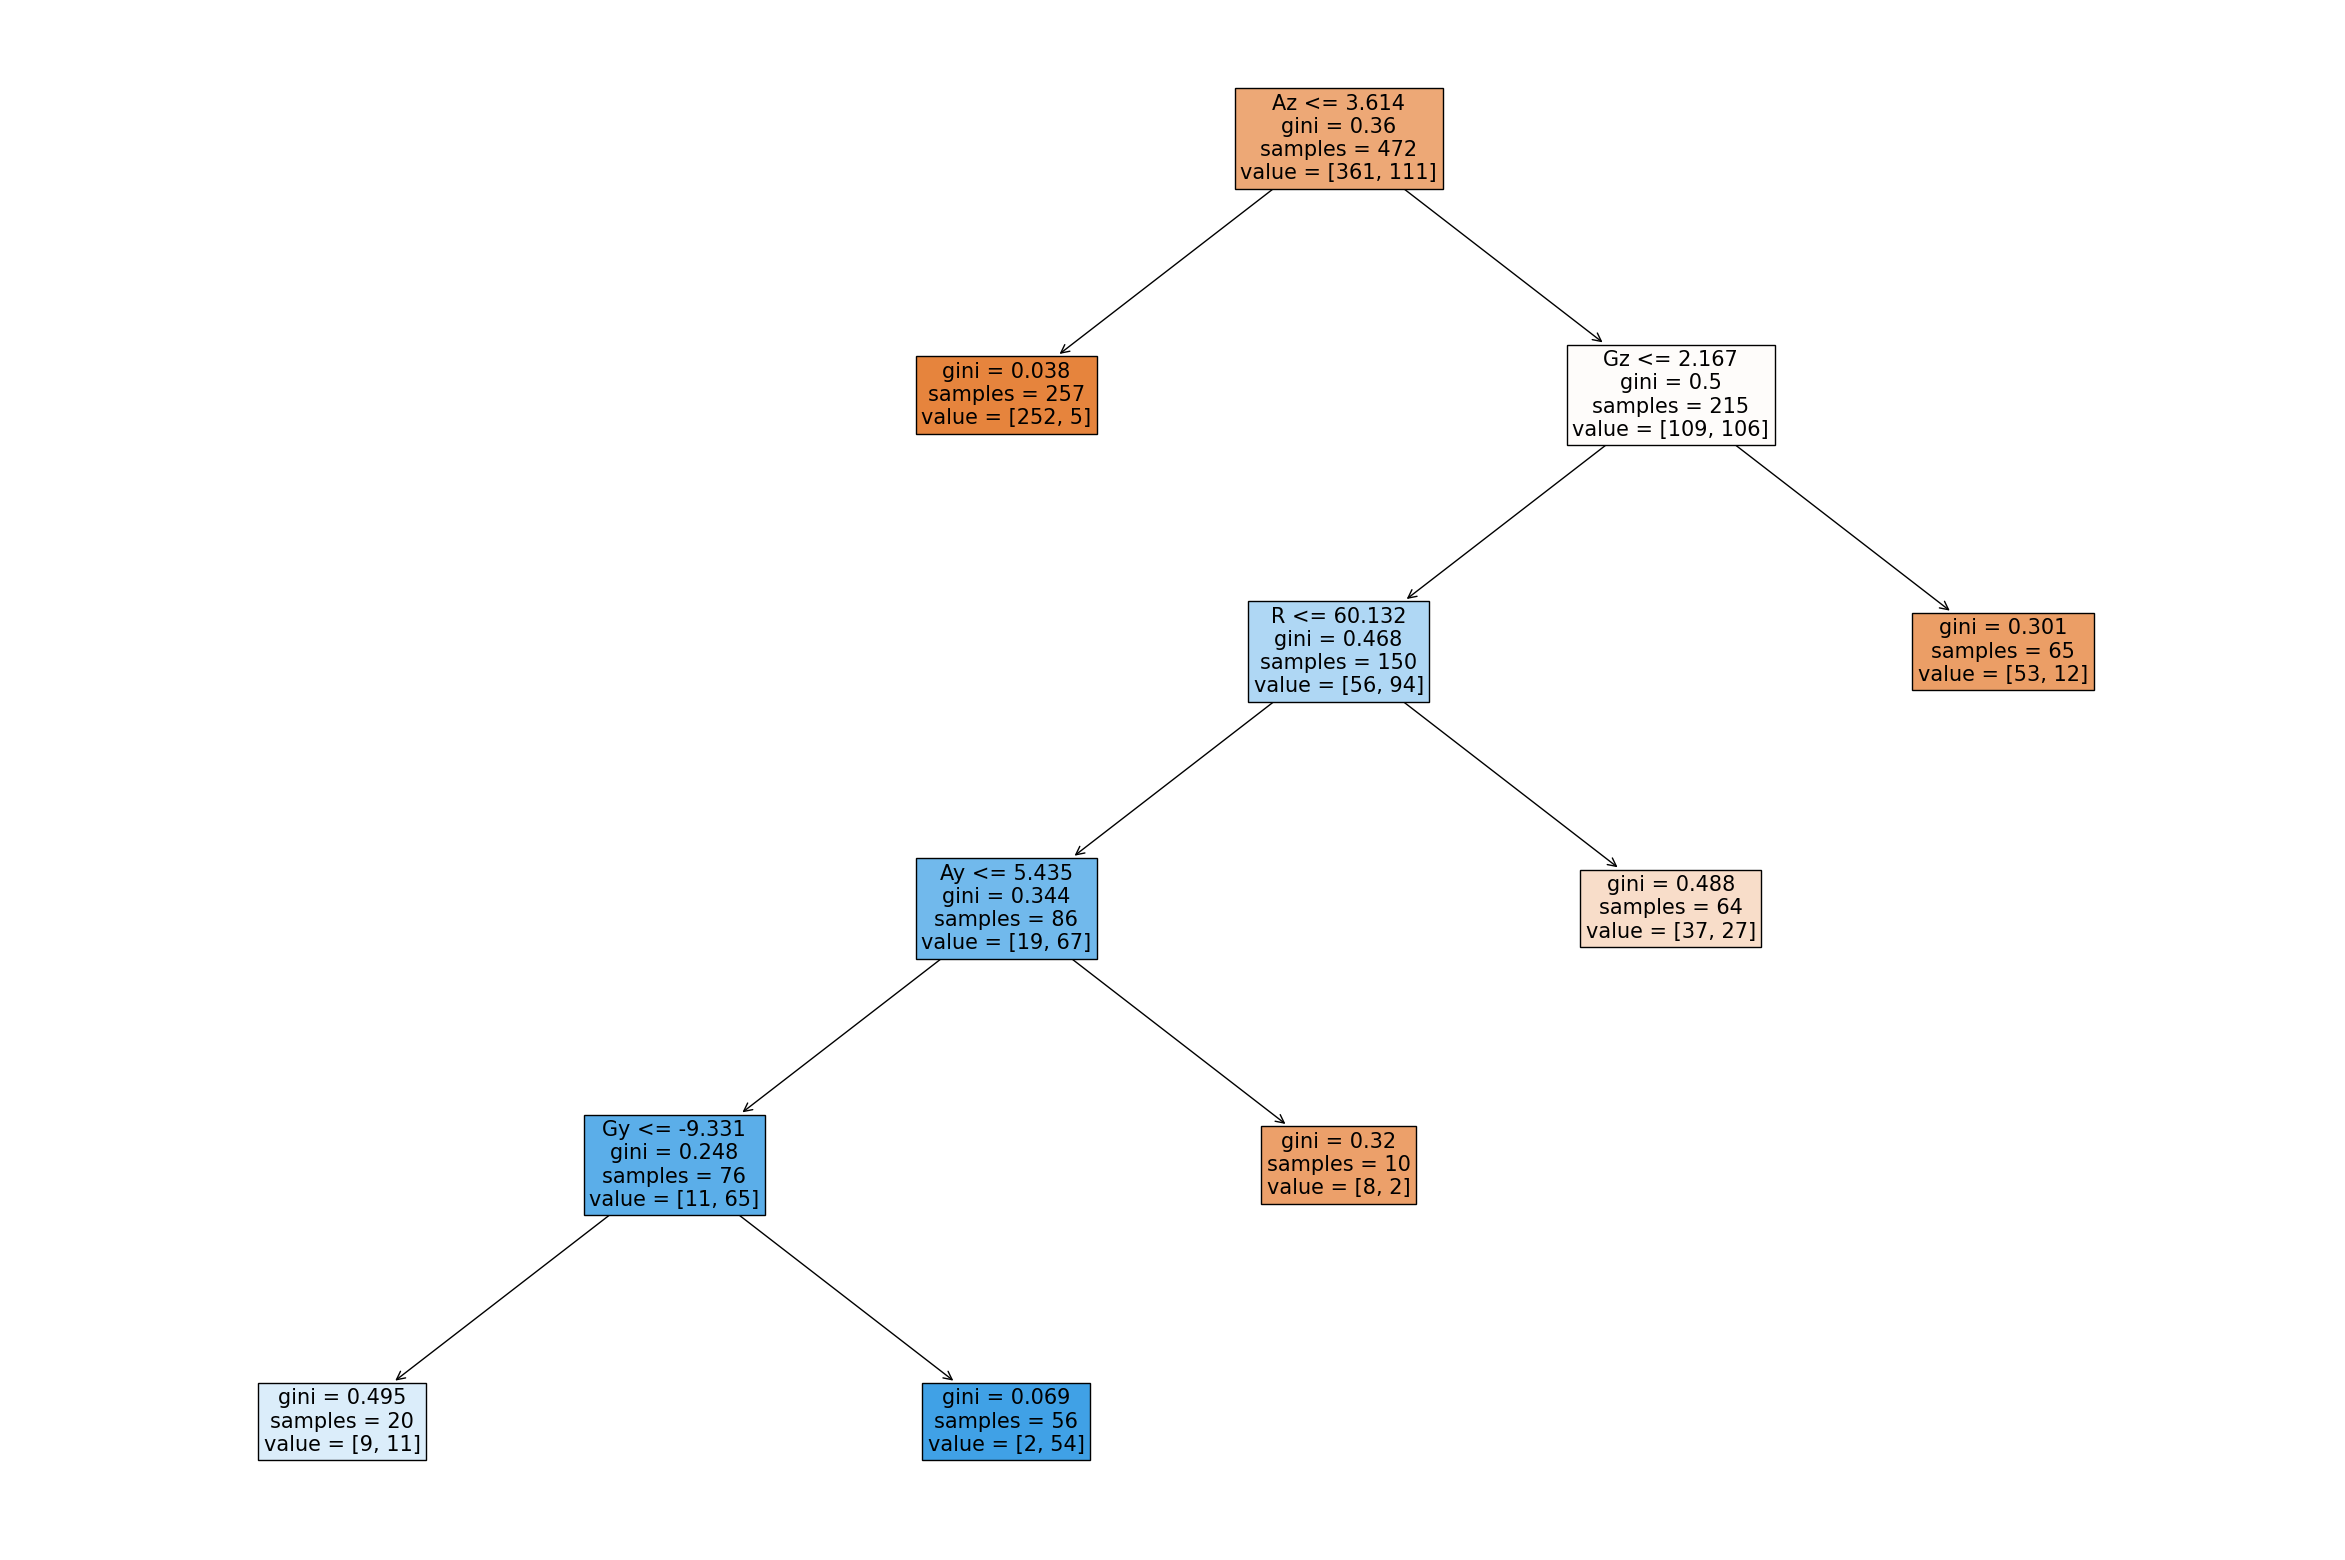

In [892]:
## Y è l'output che utilizziamo come training
## X sono le feautures, BISOGNA togliere la Y dalle colonne feautures 
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag','UP'], axis=1, inplace=True)

##Divido il campione in Train e Test
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
clf = DecisionTreeClassifier(criterion='gini', max_depth=max_lunghezza_albero , ccp_alpha=potatura)
clf = clf.fit(X_train, y_train)
param = clf.get_params()
predictions = clf.predict(X_test)
accuracy = clf.score(X_train, y_train)
precision = precision_score(y_true= y_test, y_pred=predictions)
recall = recall_score(y_true= y_test, y_pred=predictions)

print('Accuracy:  ', round(accuracy,3))
print('Precision: ', round(precision,3))
print('Recall:    ', round(recall,3))

from sklearn import tree
feature_names = X.columns
fig = plt.figure(figsize=(30,20))
_= tree.plot_tree(clf, 
        feature_names=feature_names, 
        filled=True, fontsize=15)


In [893]:
##importanza features
feature_names = X.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index=feature_names).sort_values(0, ascending=False)

print(feature_importance.head(10))
important_features = list(feature_importance[feature_importance[0]>0].index)
# feature_importance.head(10).plot(kind='bar')

            0
Az   0.569241
Gz   0.192138
R    0.101508
Ay   0.082271
Gy   0.054841
Ax   0.000000
Gx   0.000000
BAR  0.000000
P    0.000000


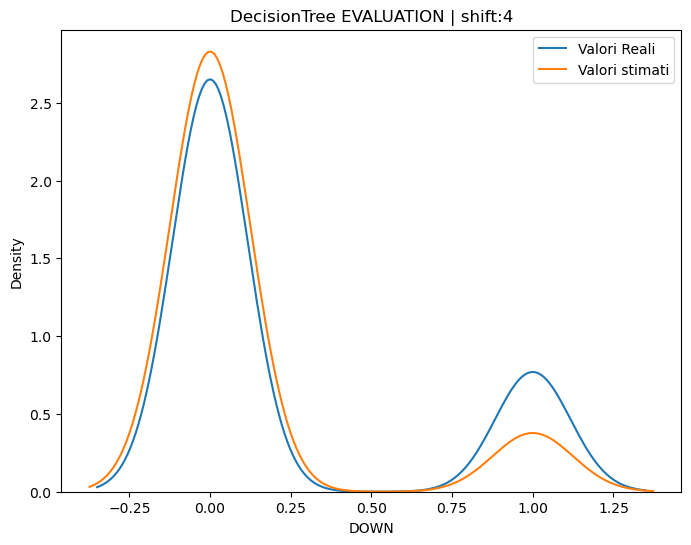

In [894]:
plt.figure(figsize=(8, 6))
plt.title('DecisionTree EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(predictions , label='Valori stimati')
plt.legend()
plt.show()

## Logistic Regression

In [895]:
log_reg = LogisticRegression(random_state=random_state, solver = 'lbfgs', max_iter=10000)
log_reg.fit(X_train, y_train)

# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

# coef_ - Coefficient of the features in the decision function
log_reg.coef_

lr = pd.DataFrame(data =[X_train.columns, np.array(log_reg.coef_[0]).tolist()]).T
lr.rename(columns={0:'Reg',1:'Logistic'}, inplace=True)
lr.set_index('Reg', inplace=True)
lr.sort_values(by='Logistic', key=abs, ascending=False , inplace=True)
print(lr)

     Logistic
Reg          
Az   0.639242
Ay  -0.596171
Ax  -0.109113
Gz  -0.105334
P   -0.077345
R   -0.073743
Gx  -0.016346
Gy   0.009987
BAR  0.002565


In [896]:
'''Logistic Regression EVALUATION'''

# Accuracy on Train
print("LogReg Training Accuracy is: ", log_reg.score(X_train, y_train))
# Accuracy on Test
print("LogReg Testing Accuracy is: ", log_reg.score(X_test, y_test))
# Classification Report


LogReg Training Accuracy is:  0.8347457627118644
LogReg Testing Accuracy is:  0.8235294117647058


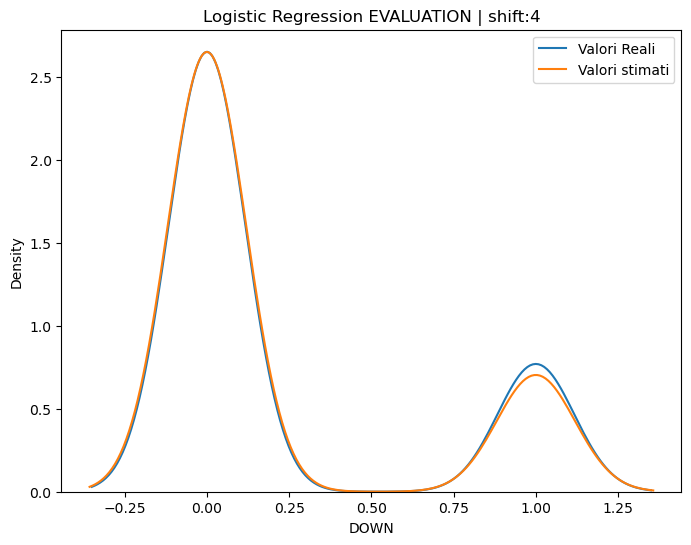

In [897]:
plt.figure(figsize=(8, 6))
plt.title('Logistic Regression EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(y_pred , label='Valori stimati')
plt.legend()
plt.show()

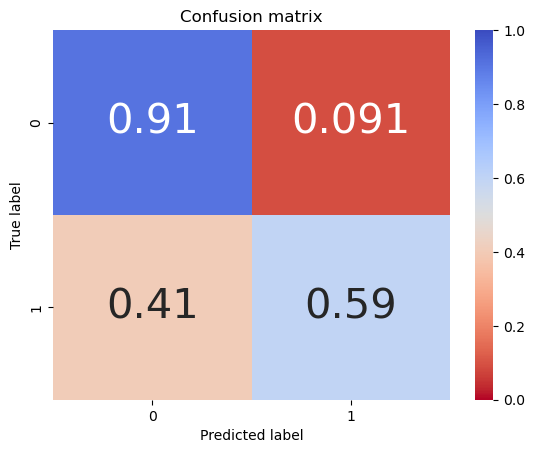

In [898]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="coolwarm_r", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    vmin=0., vmax=1., 
                    annot=True, annot_kws={'size':30}
                    )
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualizing cm

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [899]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)

The True Positive Rate is: [0.90858726 0.59459459]
The Precision is: [0.87935657 0.66666667]
The False positive rate is: [0.40540541 0.09141274]
The False Negative Rate is:  [0.09141274 0.40540541]


## Regressione Lineare Multivariata

          RLM
Reg          
BAR  0.382727
Az   0.027319
Ay  -0.023353
Gz  -0.013748
R   -0.010925
Gx  -0.002334
Ax   0.001396
Gy   0.000942
P   -0.000001
Termine noto: -378.72364943969245
 
Precisione:  0.32654814690597755


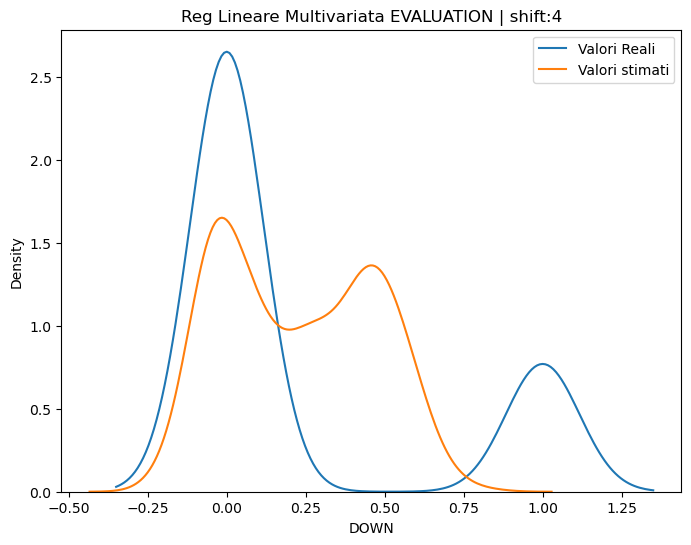

In [900]:
mlr = LinearRegression()
y = df['DOWN']
X = df.copy()
X.drop(columns=['DOWN','Mag','UP'], axis=1, inplace=True)

mlr.fit(X, y)
Y_hat = mlr.predict(X)
b0 = mlr.coef_
b1 = mlr.intercept_

reg = pd.DataFrame(data =[X.columns, b0]).T
reg.rename(columns={0:'Reg',1:'RLM'}, inplace=True)
reg.set_index('Reg', inplace=True)
reg.sort_values(by='RLM', key=abs, ascending=False , inplace=True)

print(reg)
print('Termine noto:',b1)
print(' ')
print('Precisione: ', mlr.score(X, y))

plt.figure(figsize=(8, 6))
plt.title('Reg Lineare Multivariata EVALUATION' +' | shift:'+str(shift))
sns.kdeplot(data=df, x='DOWN' , label='Valori Reali')
sns.kdeplot(Y_hat , label='Valori stimati')
plt.legend()
plt.show()
